**GET DATA**

Summary of this notebook: ...

Todo:

1. Self supervised representation learning using colorization as a pretext task
2. Taking in an image I , rotating it by an a set angle A--> rotated image (I_A), rotated angle A (actual label) (Done)
3. Dataloader that does this somehow (Done)
4. Some model-> ResNet50  + new full-connected layer (feature vector-> probability that image belongs to one of n classes) (Done-ish)
5. Additional training with the above model minimizing the loss wrt. actual rotated angle
f(I_A)=min[L(A_predict,A)]
6. Save this new model

7. Proof of concept:
Imagenet-> Train on Caltech validation on caltech




Definition of Done: ...

# Imports


In [ ]:
# Mount Google drive
from google.colab import drive
import os
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Change to current dataset
os.chdir("/content/gdrive/Shared drives/2020_FDLUSA_Earth Science_Knowledge Discovery Framework/Code")

In [ ]:
# Imports from Colab 2
import math
import numpy as np
import pickle
import keras
import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from datetime import datetime
# Import pretrained model
from tensorflow.keras.applications import MobileNet, ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

Using TensorFlow backend.


In [ ]:
# Imports for Colab 6
import cv2 # Read raw image
import glob
from google.colab.patches import cv2_imshow
from matplotlib import pyplot as plt
from scipy import ndimage # For rotation task or
import imutils
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

from tensorflow.python.keras.utils import data_utils
from tensorflow.keras.preprocessing.image import Iterator


# Imports for Colorizer
from os import path
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, UpSampling2D, AveragePooling2D, Reshape, Conv2DTranspose, ZeroPadding2D
from tensorflow.keras.layers import Activation, InputLayer, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from skimage.color import rgb2lab, lab2rgb, rgb2gray, gray2rgb
from skimage.io import imsave
import random
import tensorflow as tf

In [ ]:
# Check to see if GPU is being used
tensorflow.test.gpu_device_name()

'/device:GPU:0'

# Data Augmentation/Analysis

In [ ]:
# Raw dataset/path/model paths
dataset= "Datasets/MODIS_MCD43A4/Globe/training_set/"
# dataset = "MODIS_MCD43A4/Globe/training_set/2020169"
# dataset = "MODIS_MCD43A4/Globe/training_set/2020051"
dataPath = dataset + "*/np_arrays"
modelName = "KDF_modis"

image_globs=glob.glob(dataPath+'/*.npy')

val_ratio=int(0.1*len(image_globs))


val_image_globs=image_globs[:val_ratio]
train_image_globs=image_globs[val_ratio:]
# val_image_globs=glob.glob(dataPath+'/*.npy')

# # JUST CHECKING
# for f in train_image_globs:
#   image = np.expand_dims(np.load(f)/255., 0)
#   image = np.swapaxes(image, 0, -1)
#   if np.sum(image.shape) < (1+500+500+3):
#     continue
#   print(image.shape)

In [ ]:
print(len(train_image_globs))
print(train_image_globs[0])

19246
Datasets/MODIS_MCD43A4/Globe/training_set/2020051/np_arrays/MCD43A4.A2020051.h25v05.006.2020062235616_1200_800_400.npy


# Dataloader creation and test

In [ ]:
# dims=(500,500,3)
dims=(400,400,3)
bool_generate=False
# X_train=np.empty((0,*dims))
# chunk_prefix='Datasets/MODIS_MCD43A4/Globe/training_set/chunks/'

# if bool_generate:
#   for i,f in enumerate(train_image_globs):
#     # image=np.expand_dims(img_to_array(load_img(f,target_size=dims))/255.,0)
#     image = np.expand_dims(np.load(f),0)
#     image = np.resize(image, (1,*dims))
#     X_train=np.vstack((X_train,image))
#     if i!=len(train_image_globs):
#       # print(i)
#       if (i%100)==0:
#         chunk_fname=chunk_prefix+'modis_xtrain_{}.npy'.format(str((i)//100))
#         with open(chunk_fname,'wb') as f:
#           np.save(f,X_train,allow_pickle=True)
#         print("Chunk {} done".format((i)//100))
#         X_train=np.empty((0,*dims))
#     else:
#       chunk_fname=chunk_prefix+'modis_xtrain_{}.npy'.format(str(np.ceil((i)/100)))
#       with open(chunk_fname,'wb') as f:
#         np.save(f,X_train,allow_pickle=True)
#       print("Chunk {} done".format(np.ceil((i)/100)))
# else:
  
#   for f in glob.glob(chunk_prefix+'*.npy'):
#     chunk_data=np.load(f)
#     if len(chunk_data)==100 or f.split('/')[-1].endswith('214.npy'):
#       X_train=np.vstack((X_train,chunk_data))
#     else:
#       print("Skipping: ",f)


# train_name='modis231561_xtrain.npy'
# test_name='modis231561_xtest.npy'

# if path.exists(train_name):
#   print("Train exists")
#   X_train=np.load(train_name)
# else:
#   X_train=np.empty((0,*dims))

#   for f in train_image_globs:
#     # image=np.expand_dims(img_to_array(load_img(f,target_size=dims))/255.,0)
#     image = np.expand_dims(np.load(f),0)
#     image = np.resize(image, (1, 400, 400, 3))
#     if np.sum(image.shape) < (1+400+400+3):
#       continue
#     # print(image[1,0,0,0])
#     # print(np.mean(image[1,:,:,0]))
#     # if image[0,0,0,0]!=np.mean(image[0,:,:,0]):
#     print(image.shape, X_train.shape)
#     X_train=np.vstack((X_train,image))

#     if len(X_train)%100:
#       chunk_fname=f'modis_xtrain_{str(len(X_train)%100)}'.npy
#       with open(chunk_fname) as f:
#         np.save(f,X_train,allow_pickle=True)
  
  # with open(train_name, 'wb') as f:
  #   np.save(f,X_train,allow_pickle=True)
  
# if path.exists(test_name):
#   print("Test exists")
#   X_test=np.load(test_name)
# else:
#   X_test=np.empty((0,*dims))

#   for f in val_image_globs:
#     image = np.expand_dims(np.load(f)/255.,0)
#     image = np.resize(image, (1, 512, 512, 3))
#     if np.sum(image.shape) < (1+512+512+3):
#       continue
#     X_test=np.vstack((X_test,image))

  # with open(test_name, 'wb') as f:
  #   np.save(f,X_test,allow_pickle=True)

In [ ]:

# class DataGenerator(data_utils.Sequence):
#     'Generates data for Keras'
#     def __init__(self, list_IDs, batch_size=32, dim=(246,246,3),
#                  n_classes=4, shuffle=True):
#         'Initialization'
#         self.dim = dim
#         self.batch_size = batch_size
#         self.list_IDs = list_IDs
#         self.shuffle = shuffle
#         self.on_epoch_end()

#     def __len__(self):
#         'Denotes the number of batches per epoch'
#         return int(np.floor(len(self.list_IDs) / self.batch_size))

#     def __getitem__(self, index):
#         'Generate one batch of data'
#         # Generate indexes of the batch
#         indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

#         # Find list of IDs
#         list_IDs_temp = [self.list_IDs[k] for k in indexes]

#         # Generate data
#         X= self.__data_generation(list_IDs_temp)

#         return X, y

#     def on_epoch_end(self):
#         'Updates indexes after each epoch'
#         self.indexes = np.arange(len(self.list_IDs))
#         if self.shuffle == True:
#             np.random.shuffle(self.indexes)

#     def __data_generation(self, list_IDs_temp):
#         'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
#         # Initialization
#         X = np.empty((self.batch_size, *self.dim))
#         # y = np.empty((self.batch_size), dtype=int)
#         # for i in range(len(list_IDs_temp)): 
#         #   temp_image=cv2.imread(list_IDs_temp[i])
#         #   h,w,_=temp_image.shape
#         #   angle_categorical=np.random.randint(low=0,high=4) # 0,1,2,3
#         #   angle=angle_categorical*90
#         #   rotated_image=rotate_image(temp_image,angle)

#         #   image_rotated_cropped = crop_around_center(
#         #     rotated_image,
#         #     *largest_rotated_rect(
#         #         w,
#         #         h,
#         #         math.radians(angle)
#         #     )
#         #   )
#         #   h,w,_=image_rotated_cropped.shape
#         #   center=(h//2,w//2)
#         #   d_h=246
#         #   X[i,]= image_rotated_cropped[int(center[0]-d_h/2):int(center[0]+d_h/2), int(center[1]-d_h/2):int(center[1]+d_h/2)]
#         #   y[i]=angle_categorical

#         return X

In [ ]:
# train_dataGenerator = ImageDataGenerator(rotation_range=20,
#                                    width_shift_range=0.1,
#                                    height_shift_range=0.1,
#                                    zoom_range=0.1,
#                                    horizontal_flip=True)

batch_size = 32

class CustomDataGenerator(data_utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, batch_size=batch_size, dim=(400,400,3), shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X,y= self.__data_generation(list_IDs_temp)
        #print(X.shape,y.shape)
        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim))
        for i,f in enumerate(list_IDs_temp):
            X[i,]=np.load(f)

        gray_batch=rgb2gray(X)

        X_batch=gray_batch[:,:,:]/255. #(16,400,400)
        X_batch=np.repeat(np.expand_dims(X_batch,3),3,axis=3)
        Y_batch=X[:,:,:,:]/255.
        return X_batch,Y_batch

print("LEN TRAINING:",len(train_image_globs))
train_dataGenerator=CustomDataGenerator(train_image_globs)


LEN TRAINING: 19246


In [ ]:
# def image_a_b_gen(batch_size):
#     for batch in train_dataGenerator.flow(X_train, batch_size=batch_size):
#         gray_batch = rgb2gray(batch)
        
#         X_batch = gray_batch[:,:,:]/255.
#         Y_batch = batch[:,:,:,:]/255.
#         print(np.max(X_batch),np.min(X_batch),np.max(Y_batch),np.min(Y_batch))
#         yield (X_batch.reshape(X_batch.shape+(1,)), Y_batch)

# dataset= "Datasets/MODIS_MCD43A4/Globe/training_set/"
# def image_a_b_gen(batch_size):
#     for batch in train_dataGenerator.flow_from_directory(dataset+'2020169/', 
#                                                           batch_size=batch_size,
#                                                           target_size=(400, 400),
#                                                           color_mode="rgb",
#                                                           class_mode="input",
#                                                           shuffle=True,
#                                                           seed=42
#                                                           ):
#         gray_batch = rgb2gray(batch[0])
        
#         X_batch = gray_batch[:,:,:]/255.# Gray
#         Y_batch = batch[0][:,:,:,:]/255. # RGB
#         print(np.max(X_batch),np.min(X_batch),np.max(Y_batch),np.min(Y_batch))
#         yield (X_batch.reshape(X_batch.shape+(1,)), Y_batch)

# Model creation

In [ ]:
model = Sequential()
# model.add(InputLayer(input_shape=(256, 256, 1)))
model.add(InputLayer(input_shape=(400, 400, 3)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
# model.add(AveragePooling2D(pool_size=(2,2),padding='valid'))
model.add(AveragePooling2D(pool_size=(3,3),padding='valid'))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', strides=2))
# model.add(AveragePooling2D(pool_size=(2,2),padding='valid'))
model.add(AveragePooling2D(pool_size=(3,3),padding='valid'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
# model.add(AveragePooling2D(pool_size=(3,3),padding='valid'))
# model.add(AveragePooling2D(pool_size=(2,2),padding='valid'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', strides=2))
# model.add(AveragePooling2D(pool_size=(3,3),padding='valid'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
# model.add(AveragePooling2D(pool_size=(3,3),padding='valid'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2))) # extra
# model.add(UpSampling2D((3, 3))) # extra
model.add(ZeroPadding2D((1, 1))) # extra
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
# model.add(Conv2D(64, (3, 3), activation='relu', padding='valid'))
model.add(UpSampling2D((2, 2))) # extra
model.add(UpSampling2D((2, 2))) # extra
model.add(Conv2D(3, (3, 3), activation='tanh', padding='same'))
model.add(UpSampling2D((2, 2)))


# Model Training

In [ ]:
# model.compile(optimizer='rmsprop', loss='mse', metrics = ['accuracy'])
# model.compile(optimizer='adadelta',loss='binary_crossentropy',metrics=['accuracy'])


from keras import backend as K
def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return 1 - K.mean(f1)

model.compile(optimizer='adam',loss=[tf.keras.losses.BinaryCrossentropy(),f1_loss],loss_weights=[0.5, 0.5],metrics=['accuracy',f1,tf.keras.metrics.BinaryCrossentropy()])

callback_earlystop=EarlyStopping(monitor='loss',patience=5)

checkpoint_filepath = 'Models/checkpoint/model2_{epoch:04d}.h5'
callback_checkpoint = ModelCheckpoint(
     filepath=checkpoint_filepath,
     save_weights_only=False,
     period=1)



# checkpoint_filepath = '/tmp/checkpoint'
# callback_checkpoint = ModelCheckpoint(
#     filepath=checkpoint_filepath,
#     save_weights_only=False,
#     monitor='train_acc',
#     mode='max',
#     save_best_only=True)


model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 400, 400, 32)      896       
_________________________________________________________________
average_pooling2d (AveragePo (None, 133, 133, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 67, 67, 32)        9248      
_________________________________________________________________
average_pooling2d_1 (Average (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 22, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 64)        36928     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 11, 11, 128)       7

In [ ]:
model.fit_generator(train_dataGenerator,
                    epochs=20,
                    steps_per_epoch=len(train_image_globs)/batch_size,
                    callbacks=[callback_earlystop,callback_checkpoint],
                    use_multiprocessing=True,
                    workers=6,
                    max_queue_size=10)

# model.fit(image_a_b_gen(batch_size),
#                     epochs=40,
#                     steps_per_epoch=len(train_image_globs)/batch_size,
#                     callbacks=[callback_earlystop,callback_checkpoint])


Epoch 1/20
602/601 [==============================] - 1197s 2s/step - loss: -619.4330 - accuracy: 0.8037 - f1: 1.9731 - binary_crossentropy: -1238.8661
Epoch 2/20
602/601 [==============================] - 1164s 2s/step - loss: -620.8271 - accuracy: 0.8054 - f1: 1.9756 - binary_crossentropy: -1241.6522
Epoch 3/20
602/601 [==============================] - 1186s 2s/step - loss: -621.0347 - accuracy: 0.8056 - f1: 1.9756 - binary_crossentropy: -1242.0695
Epoch 4/20
602/601 [==============================] - 1182s 2s/step - loss: -620.8006 - accuracy: 0.8054 - f1: 1.9756 - binary_crossentropy: -1241.6017
Epoch 5/20
602/601 [==============================] - 1174s 2s/step - loss: -620.8535 - accuracy: 0.8057 - f1: 1.9756 - binary_crossentropy: -1241.7070
Epoch 6/20
602/601 [==============================] - 1162s 2s/step - loss: -621.0278 - accuracy: 0.8056 - f1: 1.9756 - binary_crossentropy: -1242.0546
Epoch 7/20
602/601 [==============================] - 1181s 2s/step - loss: -620.9989 - 

In [ ]:
now = datetime.now()
dt_string = now.strftime("%d_%m_%H_%M")
print(dt_string)
model.save('Models/Colorization_MODIS_Exp_Custom_' + dt_string)

## Model Testing

In [ ]:
# X_test_m = rgb2gray(X_train)[:,:,:]
# X_test_m = X_test_m.reshape(X_test_m.shape+(1,))
# Y_test = (X_train)[:,:,:,:]
# Y_test = Y_test / 255.
# print(model.evaluate(X_test_m, Y_test, batch_size=batch_size))

3/3 [==============================] - 1s 240ms/step - loss: 0.3335 - accuracy: 0.9058
[0.33350008726119995, 0.9057626724243164]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


23 ./Datasets/training_set_tmp2/2004031/np_arrays/MCD43A4.A2004031.h21v11.006.2016112020923_1344_2240_448.npy


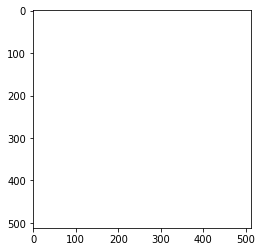

In [ ]:
# # while True:
# rand_index=np.random.randint(0,len(train_image_globs))
# print(rand_index,train_image_globs[rand_index])
# sample_image = np.expand_dims(np.load(train_image_globs[rand_index])/255.,0)
# # if np.sum(sample_image.shape) == (1+500+500+3):
# #   continue
# sample_image = np.resize(sample_image, (1, 512, 512, 3))

# # sample_image=img_to_array(load_img(val_image_globs[rand_index]))
# # sample_image=np.expand_dims(sample_image/255.,0)

# sample_image_x=rgb2gray(sample_image)[:,:,:]
# sample_image_x=sample_image_x.reshape(sample_image_x.shape+(1,))

# # Test model
# output = model.predict(sample_image_x)
# # output = output * 255.

# # Output colorizations
# for i in range(len(output)):
#     # cur = np.zeros((512, 512, 3))
#     # cur[:,:,0] = sample_image_x[i][:,:,0]
#     cur[:,:,0:] = output[i]
#     # imsave("Models/colorization_out/img_"+str(rand_index)+ dt_string + ".png", gray2rgb(cur))
#     # imsave("Models/colorization_out/raw_img_"+str(rand_index)+ dt_string +".png",np.squeeze(sample_image))

#     plt.imshow(cur)
#     plt.show()

In [ ]:
# np.max(sample_image)
# # np.min(output)

128.49803921568628